# Análisis Exploratorio y Preprocesamiento de Datos
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Analizar datos y preprocesar para predecir múltiples características de vuelo usando datos meteorológicos.

**Autor:** Estanislao  
**Fecha:** Noviembre 2024

---

## ⚠️ IMPORTANTE: Este notebook SOLO hace EDA y Preprocesamiento

**Feature Engineering se hará en un notebook separado más adelante.**

---

## Estructura del Notebook

### PARTE 1: ANÁLISIS EXPLORATORIO (EDA)
1. Setup y Carga de Datos
2. Resumen del Dataset
3. Análisis de Targets
4. Correlaciones
5. Evolución Temporal (estacionalidad)
6. Detección de Outliers

### PARTE 2: PREPROCESAMIENTO
7. Identificación y Limpieza de Columnas
8. Tratamiento de Outliers
9. Imputación de Missing Values
10. Features de Fourier (OBLIGATORIO por datos horarios)
11. Split Temporal
12. Escalado
13. Guardado

---
# PARTE 1: ANÁLISIS EXPLORATORIO

---

## 1. Setup y Carga de Datos

In [1]:
# Imports
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar utils al path
sys.path.append('../utils')

from data_processing import *
from eda_functions import *

# Configurar visualización
configurar_visualizacion()

print("✓ Módulos importados correctamente")

✓ Módulos importados correctamente


In [2]:
# Cargar dataset
df = cargar_dataset('../data/processed/dataset_FINAL.csv')

print(f"\nPrimeras filas:")
df.head()

✓ Dataset cargado: (387, 237)

Primeras filas:


,fecha,pilot,glider,competition_id,altura_max_m,altura_min_m,altura_despegue_m,altura_aterrizaje_m,ganancia_altura_m,rango_altura_m,...,meteo_wind_v_p100,meteo_pressure_p100,meteo_boundary_layer_height_p100,meteo_cape_p100,meteo_skin_temp_p100,meteo_wind_speed_p100,calidad_dia,mes,dia_año,dia_semana
0,2024-01-08,Miguel Serrano,ASW-20,AJ,1282,98,107,101,1181,1184,...,0.849823,998.664219,1249.863159,464.080933,30.811945,1.508274,Regular,1,8,0
1,2024-01-08,Miguel Angel Serrano,401 Kestrel 19m,AT,1348,111,114,117,1234,1237,...,0.849823,998.664219,1249.863159,464.080933,30.811945,1.508274,Regular,1,8,0
2,2024-01-12,Unknown,Unknown,NaN,1471,110,111,111,1360,1361,...,-1.991763,1004.280781,1318.183105,192.039566,31.297418,3.246523,Regular,1,12,4
3,2024-01-12,Miguel Angel Serrano,401 Kestrel 19m,AT,1262,115,127,126,1136,1147,...,-1.991763,1004.280781,1318.183105,192.039566,31.297418,3.246523,Regular,1,12,4
4,2024-01-13,Unknown,Jantar St2,NaN,1436,86,114,86,1350,1350,...,-3.478541,998.629375,1348.758301,382.272400,31.663751,3.689820,Regular,1,13,5


## 2. Resumen del Dataset

In [3]:
resumen_dataset(df)

RESUMEN DEL DATASET

Dimensiones: 387 filas x 237 columnas

Rango temporal: 2024-01-08 a 2025-11-15
Días únicos: 91

TIPOS DE DATOS
float64           213
int64              16
object              7
datetime64[ns]      1
Name: count, dtype: int64

VALORES FALTANTES
                                    n_missing  pct_missing
meteo_wind_v_hora_6                       386        99.74
meteo_precipitation_hora_6                386        99.74
meteo_skin_temp_hora_6                    386        99.74
meteo_cape_hora_6                         386        99.74
meteo_boundary_layer_height_hora_6        386        99.74
meteo_pressure_hora_6                     386        99.74
meteo_wind_speed_hora_6                   386        99.74
meteo_wind_u_hora_6                       386        99.74
meteo_cloud_cover_hora_6                  386        99.74
meteo_solar_rad_hora_6                    386        99.74
meteo_temp_2m_hora_6                      386        99.74
meteo_cloud_cover_hora_5   

## 3. Análisis de Targets

### ¿Qué vamos a predecir?

**Targets de Regresión (11 variables):**
1. `altura_max_m` - Altura máxima alcanzada
2. `altura_min_m` - Altura mínima
3. `ganancia_altura_m` - Ganancia total de altura
4. `duracion_horas` - Duración del vuelo
5. `duracion_min` - Duración en minutos
6. `distancia_km` - Distancia recorrida
7. `velocidad_promedio_kmh` - Velocidad promedio
8. `num_termicas` - Número de térmicas usadas
9. `intensidad_termicas_mean_ms` - Intensidad promedio de térmicas
10. `tiempo_en_termicas_min` - Tiempo en térmicas
11. `tasa_ascenso_mean_ms` - Tasa de ascenso promedio

**Target de Clasificación:**
- `calidad_dia` - Excelente / Bueno / Regular / Malo

In [4]:
# Definir todos los targets
targets_reg = [
    'altura_max_m',
    'altura_min_m',
    'ganancia_altura_m',
    # 'duracion_horas',
    'duracion_min',
    # 'distancia_km',
    'velocidad_promedio_kmh',
    'num_termicas',
    'intensidad_termicas_mean_ms',
    'tiempo_en_termicas_min',
    'tasa_ascenso_mean_ms'
]

target_clf = 'calidad_dia'

# Analizar
analizar_targets(df, targets_reg, target_clf)

ANÁLISIS DE TARGETS

▶ TARGETS DE REGRESIÓN:

altura_max_m:
  Media: 2231.61
  Mediana: 2009.00
  Std: 3417.99
  Min: 560.00
  Max: 64500.00

altura_min_m:
  Media: 137.28
  Mediana: 118.00
  Std: 59.34
  Min: 2.00
  Max: 212.00

ganancia_altura_m:
  Media: 2091.41
  Mediana: 1861.00
  Std: 3410.69
  Min: 528.00
  Max: 64299.00

duracion_min:
  Media: 197.44
  Mediana: 202.00
  Std: 72.81
  Min: 12.30
  Max: 404.20

velocidad_promedio_kmh:
  Media: 116.26
  Mediana: 118.20
  Std: 18.71
  Min: 54.70
  Max: 161.70

num_termicas:
  Media: 109.14
  Mediana: 102.00
  Std: 69.99
  Min: 1.00
  Max: 323.00

intensidad_termicas_mean_ms:
  Media: 2.65
  Mediana: 2.56
  Std: 0.58
  Min: 0.47
  Max: 6.73

tiempo_en_termicas_min:
  Media: 76.60
  Mediana: 78.70
  Std: 29.11
  Min: 3.20
  Max: 152.40

tasa_ascenso_mean_ms:
  Media: 2.70
  Mediana: 2.45
  Std: 1.11
  Min: 1.51
  Max: 9.74

▶ TARGET DE CLASIFICACIÓN (calidad_dia):
calidad_dia
Bueno        248
Excelente     69
Malo          10
Regular 

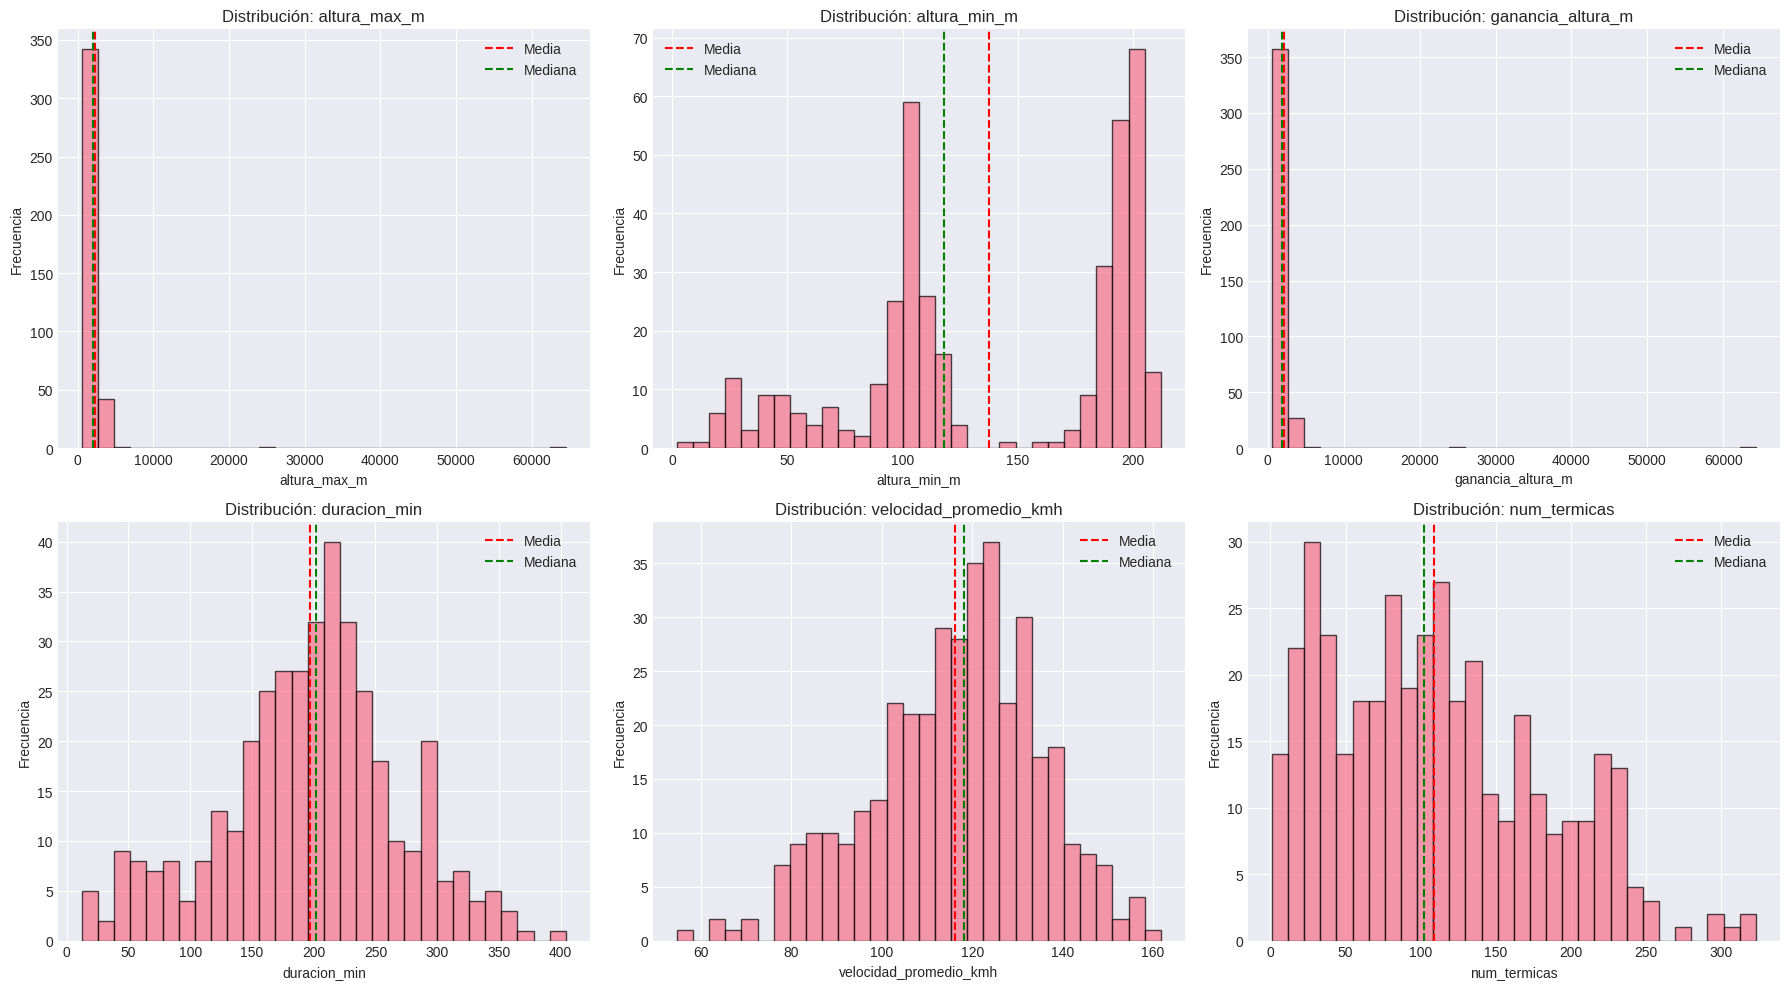

In [5]:
# Visualizar distribuciones de los primeros 6 targets
plot_distribucion_targets(df, targets_reg[:6], None)

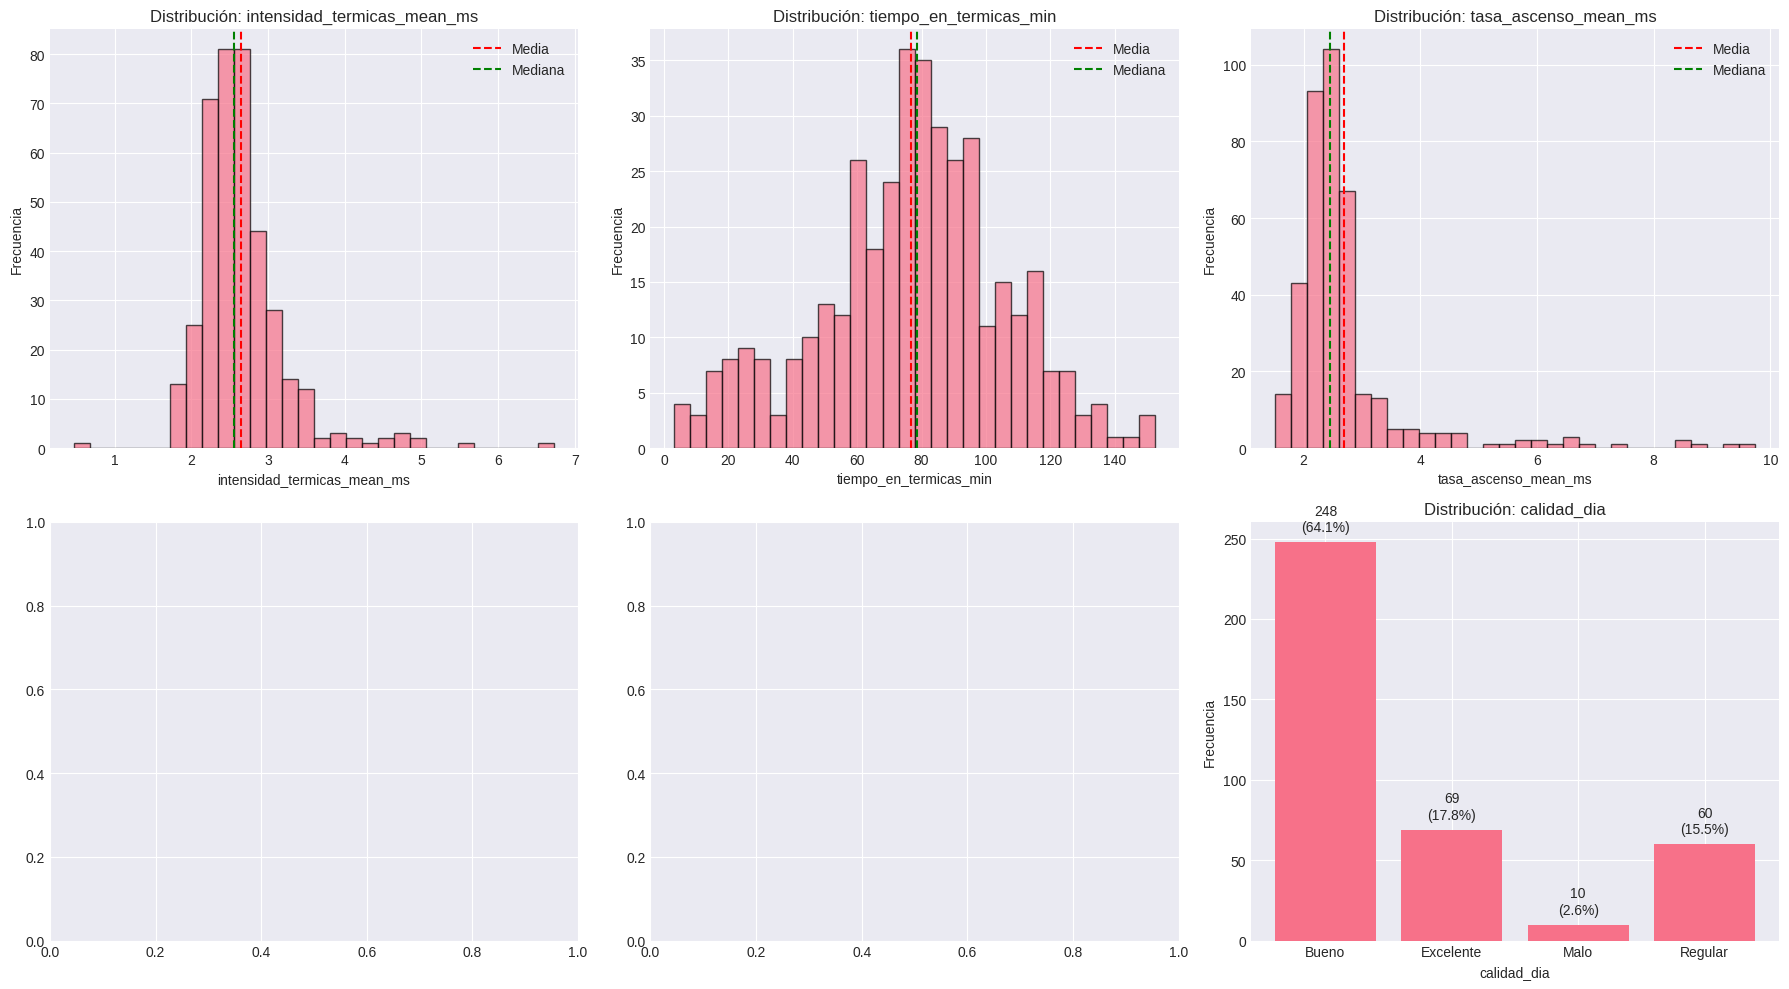

In [6]:
# Visualizar el resto + clasificación
plot_distribucion_targets(df, targets_reg[6:], target_clf)

## 4. Correlaciones con Targets

**¿Qué features meteorológicas son más importantes?**

In [7]:
# Analizar correlaciones para altura_max_m
analizar_correlaciones(df, ['altura_max_m'], top_n=20)

CORRELACIONES CON TARGETS

▶ TOP 20 CORRELACIONES CON altura_max_m:
ganancia_altura_m                     0.999855
rango_altura_m                        0.999851
cambio_altura_std_m                   0.980337
altura_std_m                          0.842380
altura_cv                             0.787651
meteo_boundary_layer_height_hora_5    0.736426
meteo_skin_temp_hora_5                0.733928
ground_speed_max_kmh                  0.670973
meteo_wind_v_hora_5                   0.669482
meteo_temp_2m_hora_5                  0.624093
meteo_wind_speed_hora_5               0.542308
meteo_boundary_layer_height_p100      0.452806
meteo_cape_hora_5                     0.448588
meteo_cloud_cover_hora_5              0.388099
meteo_solar_rad_hora_5                0.343936
meteo_wind_v_p100                     0.326789
meteo_pressure_hora_5                 0.284660
ground_speed_std_kmh                  0.279703
meteo_skin_temp_p100                  0.217501
frecuencia_muestreo_seg               0

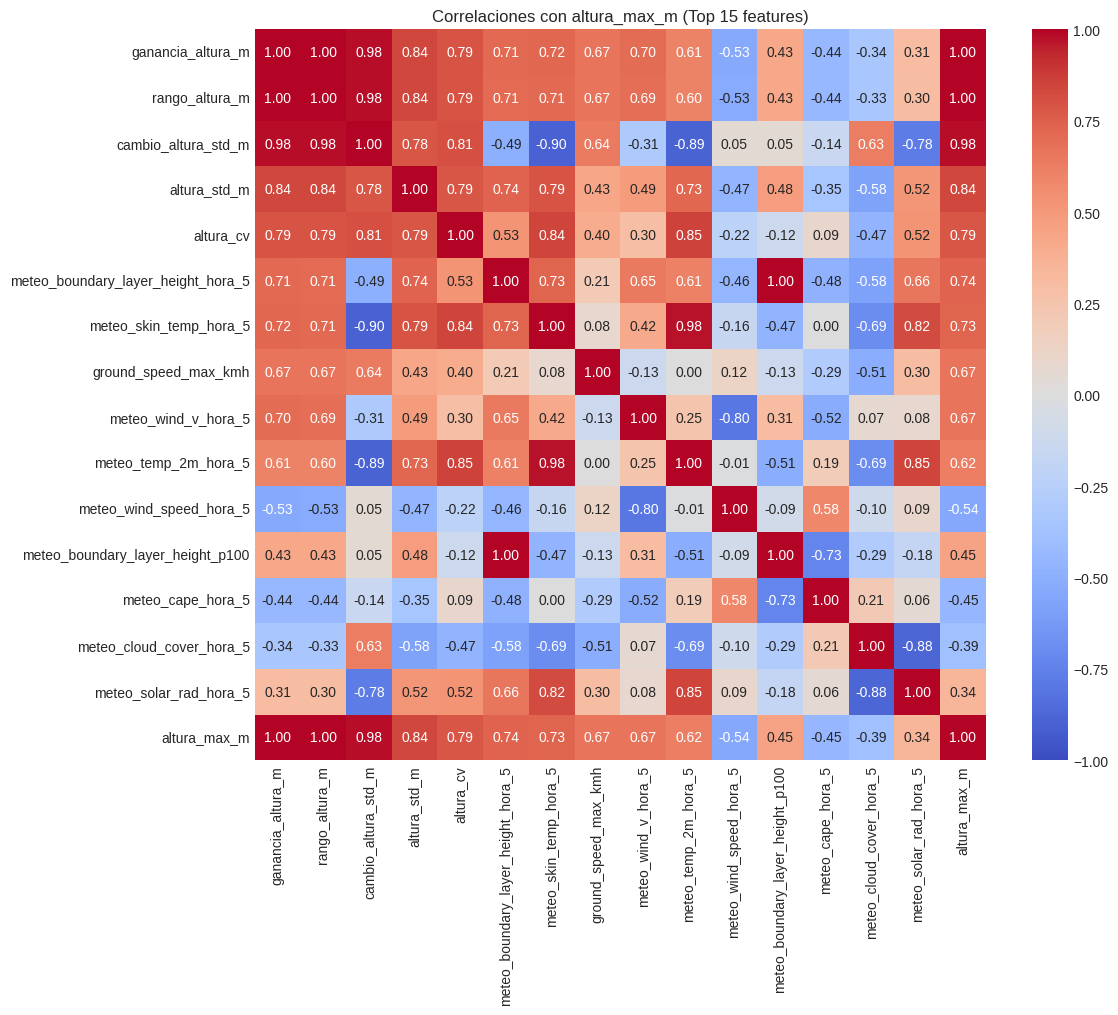

In [8]:
# Heatmap para altura_max_m
plot_correlacion_heatmap(df, ['altura_max_m'], top_n=15)

In [9]:
# Correlaciones para duracion_horas
analizar_correlaciones(df, ['duracion_horas'], top_n=20)

CORRELACIONES CON TARGETS

▶ TOP 20 CORRELACIONES CON duracion_horas:
duracion_min                   0.999997
tiempo_en_planeo_min           0.986661
tiempo_en_termicas_min         0.967455
distancia_km                   0.939042
distancia_max_despegue_km      0.806303
rango_lon_deg                  0.794707
dispersion_termicas_lon        0.779800
hora_fin_decimal               0.771097
hora_ultima_termica            0.759455
area_vuelo_km2                 0.751921
rango_lat_deg                  0.741414
dispersion_termicas_lat        0.727173
altura_tope_termicas_max_m     0.651996
num_gps_fixes                  0.650461
altura_base_termicas_mean_m    0.642832
altura_tope_termicas_mean_m    0.636551
num_termicas                   0.605555
ground_speed_mean_kmh          0.567421
velocidad_promedio_kmh         0.513174
hora_inicio_decimal            0.488138
Name: duracion_horas, dtype: float64


## 5. Evolución Temporal

### ¿Qué es la Evolución Temporal?

**Definición:** Cómo cambian los targets a lo largo del tiempo.

**¿Por qué es importante?**
- Detecta **estacionalidad** (mejores vuelos en verano vs invierno)
- Detecta **tendencias** (mejoras con el tiempo, aprendizaje de pilotos)
- Justifica usar **features temporales** (mes, día del año)

**Ejemplo:**
- En Argentina: verano (dic-feb) → mejores térmicas → vuelos más altos
- Invierno (jun-ago) → térmicas débiles → vuelos más bajos

**Lo que vamos a ver:**
1. Gráfico de altura máxima vs fecha → ¿Hay patrón estacional?
2. Promedio por mes → ¿Qué meses son mejores?
3. Media móvil → Tendencia suavizada

In [10]:
# Análisis temporal
analizar_evolucion_temporal(df, ['altura_max_m', 'duracion_horas'])

EVOLUCIÓN TEMPORAL

Promedio por mes:
     altura_max_m  duracion_horas
mes                              
1         2634.56            3.77
2         2083.20            3.18
3         1179.50            1.53
4         1108.20            1.78
5         2328.00            2.43
7         1000.50            1.52
8         1566.43            2.06
9         1525.53            2.27
10        1754.75            2.76
11        1888.33            3.43
12        2047.89            2.83


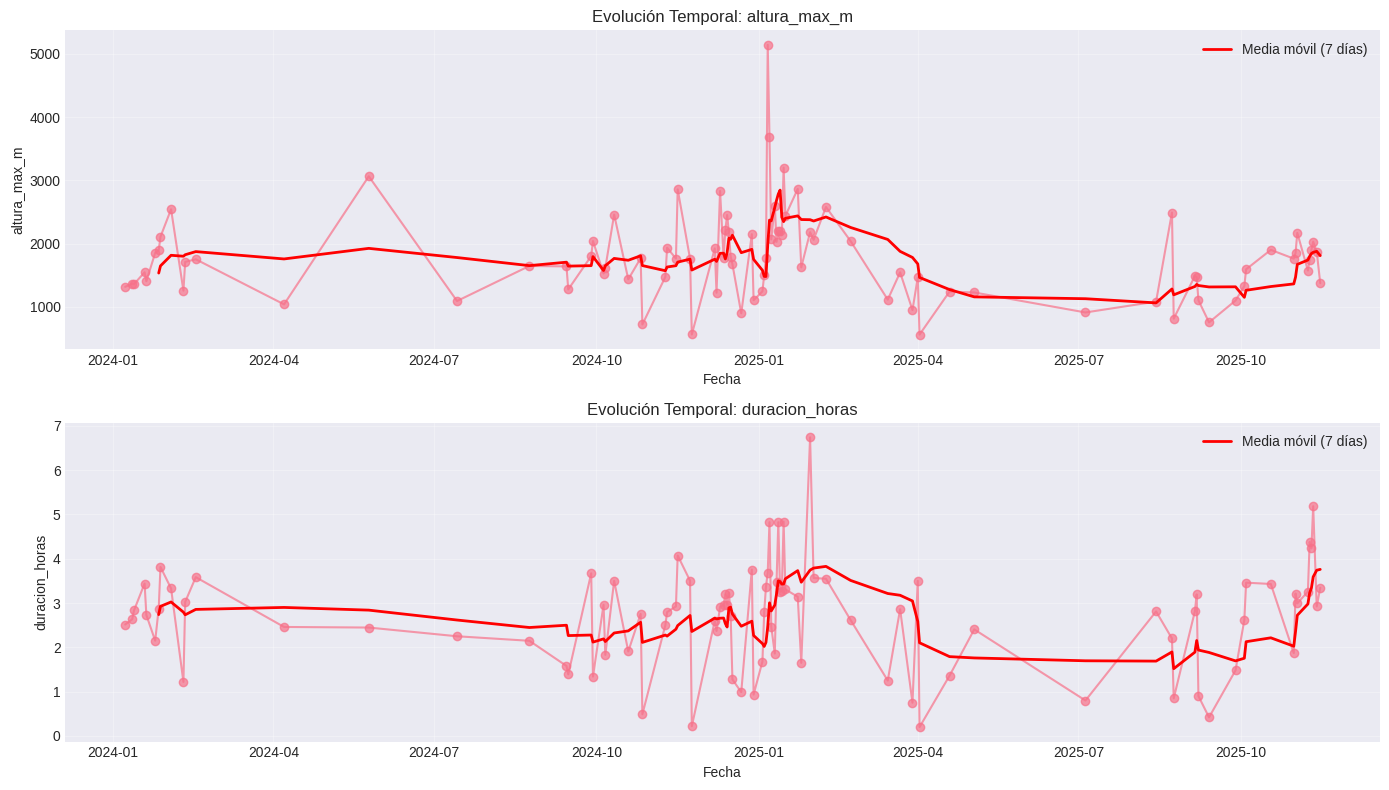

In [11]:
# Visualizar evolución temporal
plot_evolucion_temporal(df, ['altura_max_m', 'duracion_horas'])

### Interpretación de Evolución Temporal:

**¿Qué buscar en los gráficos?**

1. **Estacionalidad:**
   - ¿Los puntos suben/bajan en ciertos meses?
   - ¿Hay un patrón que se repite?
   
2. **Tendencia:**
   - ¿La línea roja (media móvil) sube, baja o se mantiene?
   - Subida → Mejora con el tiempo
   - Bajada → Empeora
   - Plana → Estable
   
3. **Variabilidad:**
   - ¿Puntos muy dispersos? → Condiciones variables
   - ¿Puntos concentrados? → Condiciones estables

**Conclusión esperada:**
- Si HAY estacionalidad → Features temporales (mes, día) son IMPORTANTES
- Si NO hay estacionalidad → Features temporales menos críticas

## 6. Detección de Outliers

**Outliers** = Valores extremos que se alejan mucho del resto.

**Ejemplos:**
- Un vuelo de 8000m cuando el promedio es 2000m
- Una duración de 10 horas cuando el promedio es 3 horas

**¿Por qué importan?**
- Pueden ser **errores** (sensor mal calibrado)
- Pueden ser **reales** (día excepcional)
- Afectan el entrenamiento del modelo

In [12]:
# Detectar outliers en los targets principales
outliers_info = detectar_outliers(df, ['altura_max_m', 'duracion_horas', 'distancia_km'], metodo='iqr')

if len(outliers_info) > 0:
    print("\nOutliers detectados:")
    display(outliers_info)
else:
    print("✓ No se detectaron outliers significativos")


Outliers detectados:


,columna,n_outliers,pct_outliers,valores_outliers
0,altura_max_m,20,5.167959,"[6278, 720, 3221, 562, 728]"
1,duracion_horas,8,2.067183,"[0.49, 0.22, 0.32, 0.34, 6.74]"
2,distancia_km,4,1.033592,"[846.2, 864.6, 848.9, 899.0]"


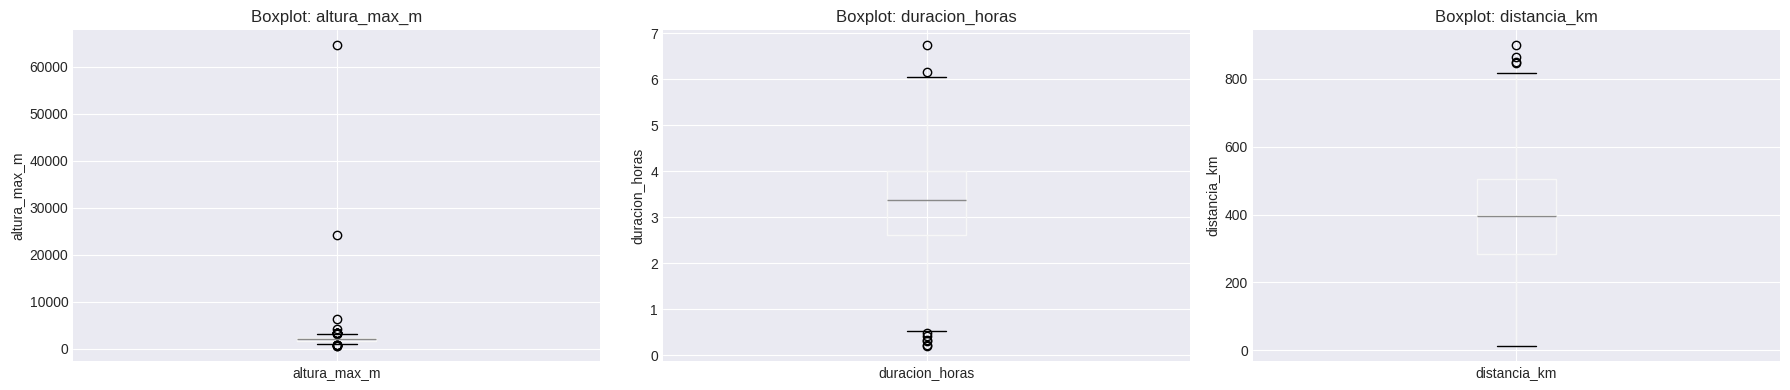

In [13]:
# Boxplots para visualizar outliers
plot_boxplots(df, ['altura_max_m', 'duracion_horas', 'distancia_km'])

---
# PARTE 2: PREPROCESAMIENTO

---

## 7. Identificación y Limpieza de Columnas

In [14]:
# Identificar columnas por tipo
columnas_dict = identificar_columnas(df)

print("\n" + "="*80)
print("CATEGORÍAS DE COLUMNAS")
print("="*80)

for cat, cols in columnas_dict.items():
    print(f"\n▶ {cat}: {len(cols)} columnas")
    if len(cols) <= 5:
        for c in cols:
            print(f"  - {c}")
    else:
        print(f"  Ejemplos: {cols[:3]}")


CATEGORÍAS DE COLUMNAS

▶ metadata: 6 columnas
  Ejemplos: ['fecha', 'pilot', 'glider']

▶ targets_regresion: 5 columnas
  - altura_max_m
  - duracion_horas
  - duracion_min
  - distancia_km
  - velocidad_promedio_kmh

▶ targets_clasificacion: 1 columnas
  - calidad_dia

▶ features_vuelo: 60 columnas
  Ejemplos: ['altura_min_m', 'altura_despegue_m', 'altura_aterrizaje_m']

▶ features_meteo_dia: 19 columnas
  Ejemplos: ['meteo_dia_solar_rad_total', 'meteo_dia_solar_rad_max', 'meteo_dia_precipitation_total']

▶ features_meteo_despegue: 11 columnas
  Ejemplos: ['meteo_solar_rad_despegue', 'meteo_precipitation_despegue', 'meteo_temp_2m_despegue']

▶ features_meteo_hora: 77 columnas
  Ejemplos: ['meteo_solar_rad_hora_0', 'meteo_precipitation_hora_0', 'meteo_temp_2m_hora_0']

▶ features_meteo_percentil: 55 columnas
  Ejemplos: ['meteo_solar_rad_p0', 'meteo_precipitation_p0', 'meteo_temp_2m_p0']

▶ features_temporales: 3 columnas
  - mes
  - dia_año
  - dia_semana


In [15]:
# Analizar missing values
missing_df = analizar_missing_values(df)

if len(missing_df) > 0:
    print("\nColumnas con valores faltantes:")
    display(missing_df.head(20))
else:
    print("✓ No hay valores faltantes")


Columnas con valores faltantes:


,columna,n_missing,pct_missing
meteo_wind_v_hora_6,meteo_wind_v_hora_6,386,99.74
meteo_precipitation_hora_6,meteo_precipitation_hora_6,386,99.74
meteo_skin_temp_hora_6,meteo_skin_temp_hora_6,386,99.74
meteo_cape_hora_6,meteo_cape_hora_6,386,99.74
meteo_boundary_layer_height_hora_6,meteo_boundary_layer_height_hora_6,386,99.74
meteo_pressure_hora_6,meteo_pressure_hora_6,386,99.74
meteo_wind_speed_hora_6,meteo_wind_speed_hora_6,386,99.74
meteo_wind_u_hora_6,meteo_wind_u_hora_6,386,99.74
meteo_cloud_cover_hora_6,meteo_cloud_cover_hora_6,386,99.74
meteo_solar_rad_hora_6,meteo_solar_rad_hora_6,386,99.74


In [16]:
# Eliminar columnas innecesarias
df_clean, eliminadas = eliminar_columnas_innecesarias(df, columnas_dict, umbral_nan=50, targets_a_predecir = targets_reg)

print(f"\nColumnas eliminadas ({len(eliminadas)}):")
for col in eliminadas:
    print(f"  - {col}")

✓ Columnas eliminadas: 94
✓ Columnas restantes: 143
✓ 'fecha' mantenida para split temporal

Columnas eliminadas (94):
  - glider
  - meteo_cape_hora_4
  - hora_inicio_decimal
  - meteo_pressure_hora_5
  - area_vuelo_km2
  - altura_mean_tarde1_m
  - ground_speed_min_kmh
  - bearing_change_max_deg
  - distancia_km
  - rango_lon_deg
  - porcentaje_tiempo_termicas
  - altura_cv
  - rango_lat_deg
  - tasa_descenso_mean_ms
  - hora_despegue_decimal
  - meteo_wind_v_hora_6
  - duracion_termica_mean_seg
  - hora_fin_decimal
  - altura_tope_termicas_max_m
  - competition_id
  - lon_min
  - bearing_change_std_deg
  - flight_id
  - pilot
  - meteo_cape_hora_5
  - filename
  - lat_despegue
  - altura_base_termicas_min_m
  - meteo_wind_v_hora_5
  - meteo_cloud_cover_hora_4
  - meteo_temp_2m_hora_5
  - duracion_termica_max_seg
  - ground_speed_max_kmh
  - meteo_skin_temp_hora_6
  - meteo_cloud_cover_hora_5
  - meteo_wind_speed_hora_6
  - lat_max
  - cambio_altura_std_m
  - ground_speed_mean_kmh
  -

## 8. Tratamiento de Outliers

**Estrategias:**

1. **Clip** (reemplazar por límites): Valor < límite_inf → límite_inf, Valor > límite_sup → límite_sup
2. **Winsorize**: Similar a clip pero usa percentiles (ej: 5% y 95%)
3. **Remove**: Eliminar filas con outliers

**¿Cuál usar?**
- **Clip/Winsorize:** Si querés mantener todas las muestras (dataset pequeño)
- **Remove:** Si tenés muchas muestras y los outliers son claros errores

**Recomendación:** Winsorize (mantiene datos pero reduce extremos)

In [17]:
# Función para tratar outliers
from scipy.stats.mstats import winsorize

def tratar_outliers_winsorize(df, columnas, limits=(0.05, 0.05)):
    """
    Trata outliers usando Winsorization.
    
    Args:
        df: DataFrame
        columnas: Lista de columnas
        limits: (límite_inferior, límite_superior) en percentiles
    
    Returns:
        DataFrame con outliers tratados
    """
    df_clean = df.copy()
    
    for col in columnas:
        if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col]):
            # Aplicar winsorization
            df_clean[col] = winsorize(df_clean[col].values, limits=limits)
            print(f"✓ Outliers tratados en: {col}")
    
    return df_clean

# Aplicar a targets (solo si querés, es opcional)
# Por ahora solo reportamos, no modificamos
print("Outliers detectados pero NO modificados (los modelos como RandomForest son robustos)")
print("\nSi querés tratarlos, descomenta la siguiente línea:")
print("# df_clean = tratar_outliers_winsorize(df_clean, targets_reg[:3], limits=(0.05, 0.05))")

Outliers detectados pero NO modificados (los modelos como RandomForest son robustos)

Si querés tratarlos, descomenta la siguiente línea:
# df_clean = tratar_outliers_winsorize(df_clean, targets_reg[:3], limits=(0.05, 0.05))


## 9. Imputación de Missing Values

In [18]:
# Imputar valores faltantes
df_imputed, imputers = imputar_missing_values(df_clean, estrategia='median')

# Verificar
print(f"\nNaN restantes: {df_imputed.isnull().sum().sum()}")

✓ Valores imputados: 3927

NaN restantes: 0


## 10. Features de Fourier (OBLIGATORIO)

### ¿Por qué Fourier?

**Tu profesor tiene razón:** Como tenés **datos por HORA**, hay múltiples ciclos:
- **Ciclo diario** (24 horas)
- **Ciclo semanal** (7 días)
- **Ciclo mensual** (~30 días)
- **Ciclo anual** (365 días)

**Fourier Transform** captura estos múltiples ciclos simultáneamente.

### ¿Cómo funciona?

Descompone la señal temporal en componentes de frecuencia:

```
f(t) = a₁sin(ω₁t) + b₁cos(ω₁t)  ← Captura ciclo anual
     + a₂sin(ω₂t) + b₂cos(ω₂t)  ← Captura ciclo semestral
     + a₃sin(ω₃t) + b₃cos(ω₃t)  ← Captura ciclo cuatrimestral
     + ...
```

**Componentes (k):**
- k=1: 1 ciclo por año (365 días)
- k=2: 2 ciclos por año (182.5 días cada uno)
- k=3: 3 ciclos por año (121.7 días cada uno)
- k=4: 4 ciclos por año (91.25 días cada uno)

**¿Cuántos componentes?**
- Dataset <6 meses: 2-3 componentes
- Dataset 6-12 meses: 3-4 componentes
- Dataset >12 meses: 4-6 componentes

In [19]:
def agregar_fourier_features(df, n_componentes=4):
    """
    Agrega features de Fourier basadas en día del año.
    
    Args:
        df: DataFrame con columna 'dia_año'
        n_componentes: Número de componentes de Fourier
    
    Returns:
        DataFrame con features de Fourier
    """
    df_new = df.copy()
    
    # Normalizar día del año a [0, 2π]
    t = 2 * np.pi * df['dia_año'].values / 365
    
    # Crear componentes de Fourier
    for k in range(1, n_componentes + 1):
        df_new[f'fourier_sin_{k}'] = np.sin(k * t)
        df_new[f'fourier_cos_{k}'] = np.cos(k * t)
    
    print(f"✓ {n_componentes * 2} features de Fourier creadas")
    print(f"  Componentes:")
    for k in range(1, n_componentes + 1):
        periodo = 365 / k
        print(f"    k={k}: Período ≈{periodo:.0f} días ({periodo/30:.1f} meses)")
    
    return df_new

# Aplicar Fourier
n_componentes = 4  # Ajusta según tus datos
df_fourier = agregar_fourier_features(df_imputed, n_componentes=n_componentes)

✓ 8 features de Fourier creadas
  Componentes:
    k=1: Período ≈365 días (12.2 meses)
    k=2: Período ≈182 días (6.1 meses)
    k=3: Período ≈122 días (4.1 meses)
    k=4: Período ≈91 días (3.0 meses)



Features de Fourier creadas: 8
['fourier_sin_1', 'fourier_cos_1', 'fourier_sin_2', 'fourier_cos_2', 'fourier_sin_3', 'fourier_cos_3', 'fourier_sin_4', 'fourier_cos_4']


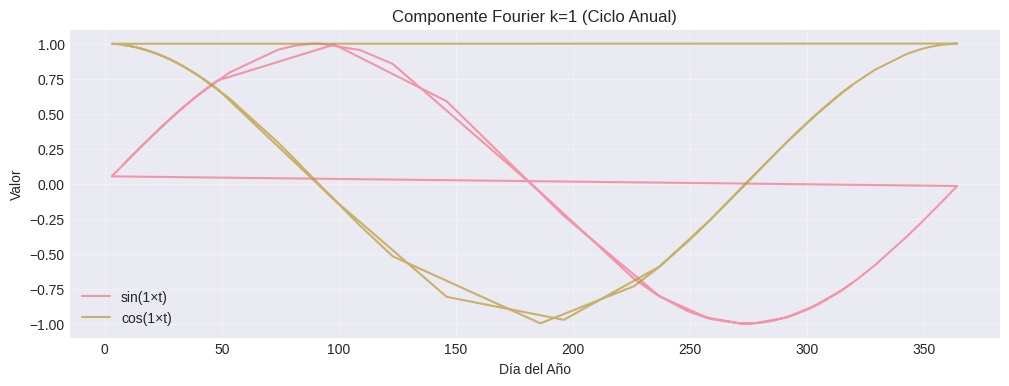

In [20]:
# Ver las nuevas features
fourier_cols = [c for c in df_fourier.columns if 'fourier' in c]
print(f"\nFeatures de Fourier creadas: {len(fourier_cols)}")
print(fourier_cols)

# Visualizar una componente
plt.figure(figsize=(12, 4))
plt.plot(df_fourier['dia_año'], df_fourier['fourier_sin_1'], label='sin(1×t)', alpha=0.7)
plt.plot(df_fourier['dia_año'], df_fourier['fourier_cos_1'], label='cos(1×t)', alpha=0.7)
plt.xlabel('Día del Año')
plt.ylabel('Valor')
plt.title('Componente Fourier k=1 (Ciclo Anual)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 11. Split Temporal

**CRÍTICO:** Split temporal (NO aleatorio) para evitar data leakage.

In [21]:
# Split temporal (70/15/15)
splits = split_temporal(df_fourier, train_pct=0.70, val_pct=0.15, test_pct=0.15)

df_train = splits['train']
df_val = splits['val']
df_test = splits['test']

SPLIT TEMPORAL
Train: 270 muestras (69.8%)
  Fechas: 2024-01-08 a 2025-01-12

Val:   57 muestras (14.7%)
  Fechas: 2025-01-13 a 2025-04-01

Test:  59 muestras (15.2%)
  Fechas: 2025-04-02 a 2025-11-15

✓ Sin superposición temporal
✓ Sin fechas compartidas entre splits


## 12. Separar Features y Targets

In [22]:
# Separar X e y para cada split
X_train, y_reg_train, y_clf_train = separar_features_targets(df_train)
X_val, y_reg_val, y_clf_val = separar_features_targets(df_val)
X_test, y_reg_test, y_clf_test = separar_features_targets(df_test)

✓ Features (X): (270, 140)
✓ Targets regresión (y_reg): (270, 9) - 9 targets
  Targets: ['altura_max_m', 'altura_min_m', 'ganancia_altura_m', 'duracion_min', 'velocidad_promedio_kmh', 'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min', 'tasa_ascenso_mean_ms']
✓ Target clasificación (y_clf): 270 muestras
✓ Features (X): (57, 140)
✓ Targets regresión (y_reg): (57, 9) - 9 targets
  Targets: ['altura_max_m', 'altura_min_m', 'ganancia_altura_m', 'duracion_min', 'velocidad_promedio_kmh', 'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min', 'tasa_ascenso_mean_ms']
✓ Target clasificación (y_clf): 57 muestras
✓ Features (X): (59, 140)
✓ Targets regresión (y_reg): (59, 9) - 9 targets
  Targets: ['altura_max_m', 'altura_min_m', 'ganancia_altura_m', 'duracion_min', 'velocidad_promedio_kmh', 'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min', 'tasa_ascenso_mean_ms']
✓ Target clasificación (y_clf): 59 muestras


In [23]:
# Verificar que 'fecha' NO está en X
if 'fecha' in X_train.columns:
    print("✗ ERROR: 'fecha' está en X_train")
else:
    print("✓ Correcto: 'fecha' NO está en X_train")

print(f"\nColumnas en X_train: {X_train.columns.tolist()[:10]}...")

✓ Correcto: 'fecha' NO está en X_train

Columnas en X_train: ['meteo_dia_solar_rad_total', 'meteo_dia_solar_rad_max', 'meteo_dia_precipitation_total', 'meteo_dia_temp_2m_max', 'meteo_dia_temp_2m_min', 'meteo_dia_temp_2m_mean', 'meteo_dia_cloud_cover_mean', 'meteo_dia_wind_u_mean', 'meteo_dia_wind_v_mean', 'meteo_dia_pressure_mean']...


## 13. Escalado

In [24]:
# Escalar features
X_train_scaled, X_val_scaled, X_test_scaled, scaler = escalar_features(
    X_train, X_val, X_test
)

✓ Features escaladas: 140
  Media train: 0.000000 (debe ser ~0)
  Std train: 1.001857 (debe ser ~1)


## 14. Guardar Datasets Procesados

In [25]:
# Preparar para guardar
splits_procesados = {
    'train': {
        'X': X_train_scaled,
        'y_reg': y_reg_train,
        'y_clf': y_clf_train
    },
    'val': {
        'X': X_val_scaled,
        'y_reg': y_reg_val,
        'y_clf': y_clf_val
    },
    'test': {
        'X': X_test_scaled,
        'y_reg': y_reg_test,
        'y_clf': y_clf_test
    }
}

# Guardar
guardar_datasets_procesados(splits_procesados, output_dir='../data/processed')
guardar_preprocesadores(imputers, scaler, output_dir='../data/processed')


✓ Datasets guardados en ../data/processed/
  - X_{train,val,test}.csv
  - y_reg_{train,val,test}.csv
  - y_clf_{train,val,test}.csv
✓ Preprocesadores guardados en ../data/processed/


## 15. Resumen Final

In [26]:
print("="*80)
print("RESUMEN FINAL")
print("="*80)

print("\n▶ DATASETS PROCESADOS:")
print(f"  X_train: {X_train_scaled.shape}")
print(f"  X_val: {X_val_scaled.shape}")
print(f"  X_test: {X_test_scaled.shape}")

if y_reg_train is not None:
    print(f"\n  y_reg_train: {y_reg_train.shape}")
    print(f"  Targets: {y_reg_train.columns.tolist()}")

print(f"\n▶ FEATURES AGREGADAS:")
print(f"  Fourier: {len([c for c in X_train_scaled.columns if 'fourier' in c])}")
print(f"  Temporales cíclicas: {len([c for c in X_train_scaled.columns if 'sin' in c or 'cos' in c]) - len([c for c in X_train_scaled.columns if 'fourier' in c])}")

print(f"\n▶ VERIFICACIONES:")
print(f"  'fecha' en X_train: {'✗ SÍ (ERROR)' if 'fecha' in X_train_scaled.columns else '✓ NO (correcto)'}")
print(f"  Overlap temporal: {'✓ NO' if df_train['fecha'].max() < df_val['fecha'].min() else '✗ SÍ (ERROR)'}")
print(f"  NaN en datos: {X_train_scaled.isnull().sum().sum() + X_val_scaled.isnull().sum().sum() + X_test_scaled.isnull().sum().sum()}")

print("\n" + "="*80)
print("✓✓✓ PREPROCESAMIENTO COMPLETADO ✓✓✓")
print("="*80)
print("\nPróximos pasos:")
print("  1. Ejecutar validar_preprocesamiento.py")
print("  2. Feature Engineering (notebook separado)")
print("  3. Modelado")

RESUMEN FINAL

▶ DATASETS PROCESADOS:
  X_train: (270, 140)
  X_val: (57, 140)
  X_test: (59, 140)

  y_reg_train: (270, 9)
  Targets: ['altura_max_m', 'altura_min_m', 'ganancia_altura_m', 'duracion_min', 'velocidad_promedio_kmh', 'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min', 'tasa_ascenso_mean_ms']

▶ FEATURES AGREGADAS:
  Fourier: 8
  Temporales cíclicas: 0

▶ VERIFICACIONES:
  'fecha' en X_train: ✓ NO (correcto)
  Overlap temporal: ✓ NO
  NaN en datos: 0

✓✓✓ PREPROCESAMIENTO COMPLETADO ✓✓✓

Próximos pasos:
  1. Ejecutar validar_preprocesamiento.py
  2. Feature Engineering (notebook separado)
  3. Modelado
